In [2]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import asdict

from pricing.products.vanilla_option import VanillaOption
from pricing.models.model_params import LewisParams, MCParams, HestonParams, FractionalVolterraHestonParams, LiftedHestonParams
from pricing.models.heston import Heston
from pricing.models.fractional_volterra_heston import FractionalVolterraHeston
from pricing.models.lifted_heston import LiftedHeston
from pricing.utility import from_delta_call_to_strike

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


### 1. All the models at the same place
- Heston
- Rough Heston
- Shifted Fractional Heston
- Lifted Heston

In [4]:
heston_params = HestonParams(V0=0.05, theta=0.06, lam=2, nu=0.6, rho=-0.4)
rough_params = FractionalVolterraHestonParams(**asdict(heston_params), H=0.1, eps=0)
shifted_params = FractionalVolterraHestonParams(**asdict(heston_params), H=0.1, eps=0.01)
lifted_params = LiftedHestonParams(**asdict(heston_params), H=0.1, n=20, r=2.5)

models = {
    "Heston": Heston(**asdict(heston_params)),
    "Rough": FractionalVolterraHeston(**asdict(rough_params)),
    "Shifted": FractionalVolterraHeston(**asdict(shifted_params)),
    "Lifted": LiftedHeston(**asdict(lifted_params))
}

### 2. Just smile

In [5]:
F0 = 100
T = 1
K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.22, ttm=T)
k = np.log(K / F0)

option_call = VanillaOption(T=T, K=K, flag="call")

OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[]

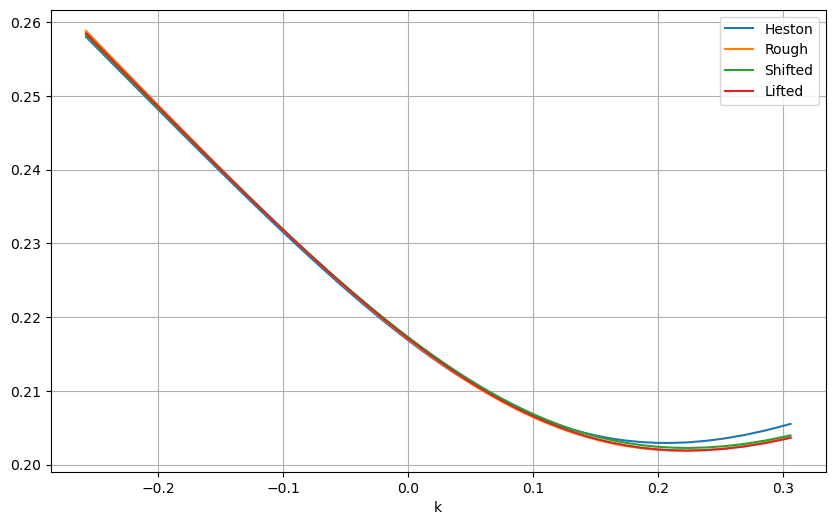

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

for name, model in models.items():
    smile = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                  pricing_params=LewisParams(cf_timestep=0.001, N_points=25))
    ax.plot(k, smile, label=name)
    
ax.grid()
ax.legend()
ax.set_xlabel('k')
plt.plot()

### 3. Pricing time

#### Heston

In [7]:
%%timeit
smile = option_call.get_price(model=models["Heston"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

2.22 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Rough Heston

In [8]:
%%timeit
smile = option_call.get_price(model=models["Rough"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

357 ms ± 9.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Shifted Fractional Heston

In [9]:
%%timeit
smile = option_call.get_price(model=models["Shifted"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

357 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Lifted Heston

In [10]:
%%timeit
smile = option_call.get_price(model=models["Lifted"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

9.17 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 4. ATM Skew

$$
\psi(T) := \left| \dfrac{\partial \sigma_{\mathrm{BS}}(T, k)}{\partial k}\right| \Bigg|_{k = 0}
 \approx \left|\dfrac{\sigma_{\mathrm{IV}}(T, \log(1 + \epsilon)) - \sigma_{\mathrm{IV}}(T, \log(1 - \epsilon))}{\log(1 + \epsilon) - \log(1 - \epsilon)}\right|
$$
with $\epsilon = 0.05$.

In [11]:
def plot_atm_skew(model, T_grid, bump=0.03, ax=None, **kwargs):
    K_skew = np.array([1 - bump, 1 + bump])
    k_skew = np.log(K_skew)

    option_call_skew = VanillaOption(T=T_grid, K=K_skew, flag="call")

    smile_skew = option_call_skew.get_price(model=model, method="lewis", F0=1, is_vol_surface=True, 
                                            pricing_params=LewisParams(cf_timestep=0.0001, N_points=25))

    atm_skew = -(np.diff(smile_skew, axis=1) / np.diff(k_skew)).squeeze()

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(T_grid, atm_skew, **kwargs)
    ax.grid("on")
    ax.set_xlabel("T")
    ax.set_title("ATM skew")

CPU times: user 8min 27s, sys: 2.35 s, total: 8min 30s
Wall time: 1min 12s


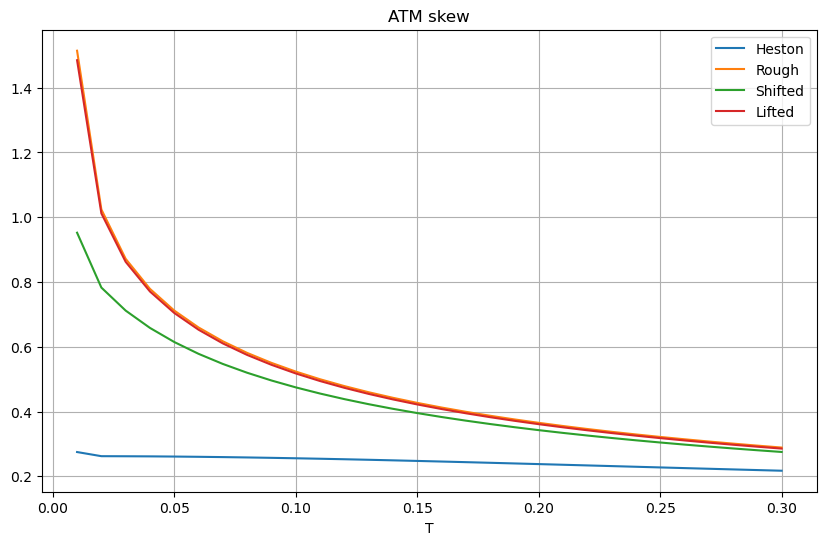

In [12]:
%%time

fig, ax = plt.subplots(figsize=(10,6))

T_skew = np.linspace(0.01, 0.3, 30)

for name, model in models.items():
    plot_atm_skew(model, T_grid=T_skew, ax=ax, label=name)
    
ax.legend()